In [ ]:
#Import Statements
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image


In [ ]:
#To connect to the drive where the datasets are present
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the three datasets and visualize them
dataset1_path = "/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 1/Colorectal Cancer"
dataset2_path = "/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 2/Prostate Cancer"
dataset3_path = "/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 3/Animal Faces"

#Define basic transform function
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#Load data
dataset1 = torchvision.datasets.ImageFolder(root=dataset1_path, transform = data_transform)
dataset2 = torchvision.datasets.ImageFolder(root=dataset2_path, transform = data_transform)
dataset3 = torchvision.datasets.ImageFolder(root=dataset3_path, transform = data_transform)

#To show dataset info
print(dataset1)
print(dataset2)
print(dataset3)

#To show the different classes in each dataset
dataset1_classes = dataset1.classes
dataset2_classes = dataset2.classes
dataset3_classes = dataset3.classes

print(dataset1_classes)
print(dataset2_classes)
print(dataset3_classes)

Dataset ImageFolder
    Number of datapoints: 6010
    Root location: /content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 1/Colorectal Cancer
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 6030
    Root location: /content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 2/Prostate Cancer
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 6020
    Root location: /content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 3/Animal Faces
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
           

In [ ]:
#Function to show the different contents of the datasats
def dataset_show_images(dataset, numImages:int, classes:list, shuffle=True):
  print('Diplaying ', numImages,  ' random images:\n')

  loader = torch.utils.data.DataLoader(dataset, batch_size=numImages, shuffle=shuffle)
  batch = next(iter(loader))
  images, labels = batch
  grid = torchvision.utils.make_grid(images, nrow = int(numImages/2))
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))

  print('The size of each image:')
  print(images[0].shape)
  print('\nThe lowest pixel value in the image tensor: ', torch.min(images[0]))
  print('\nThe highest pixel value in the image tensor: ', torch.max(images[0]))
  print('\nlabels: ', labels)
  print('Legend:')
  print('0 -> ',  str(classes[0]))
  print('1 -> ',  str(classes[1]))
  print('2 -> ',  str(classes[2]))

Diplaying  8  random images:

The size of each image:
torch.Size([3, 224, 224])

The lowest pixel value in the image tensor:  tensor(0.0784)

The highest pixel value in the image tensor:  tensor(1.)

labels:  tensor([1, 0, 2, 2, 1, 1, 0, 1])
Legend:
0 ->  MUS
1 ->  NORM
2 ->  STR


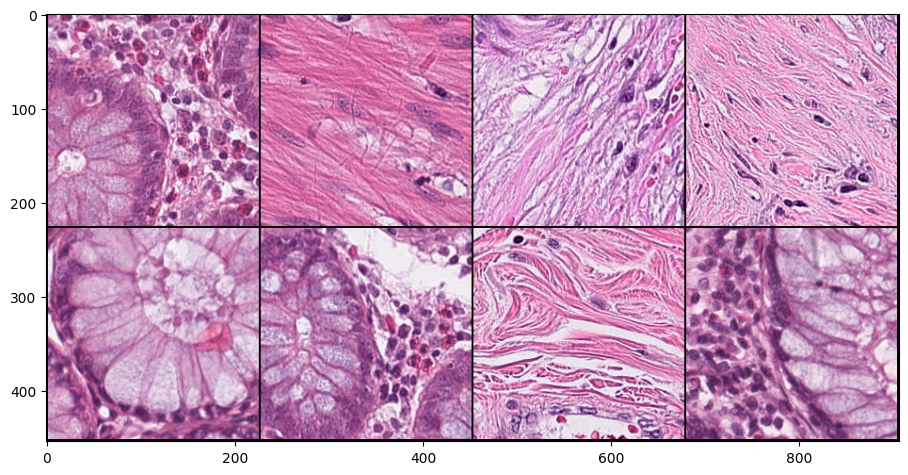

In [ ]:
#Displaying Datset 1
dataset_show_images(dataset1, 8, dataset1_classes, True)

Diplaying  8  random images:

The size of each image:
torch.Size([3, 224, 224])

The lowest pixel value in the image tensor:  tensor(0.0902)

The highest pixel value in the image tensor:  tensor(1.)

labels:  tensor([2, 0, 0, 2, 2, 0, 1, 1])
Legend:
0 ->  gland
1 ->  nongland
2 ->  tumor


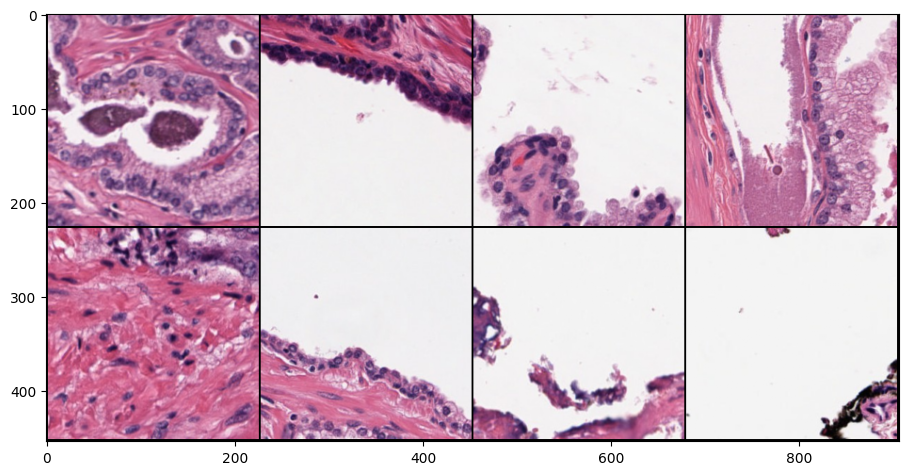

In [ ]:
#Displaying Datset 2
dataset_show_images(dataset2, 8, dataset2_classes, True)

Diplaying  8  random images:

The size of each image:
torch.Size([3, 224, 224])

The lowest pixel value in the image tensor:  tensor(0.0078)

The highest pixel value in the image tensor:  tensor(1.)

labels:  tensor([1, 2, 0, 0, 0, 1, 0, 2])
Legend:
0 ->  cat
1 ->  dog
2 ->  wild


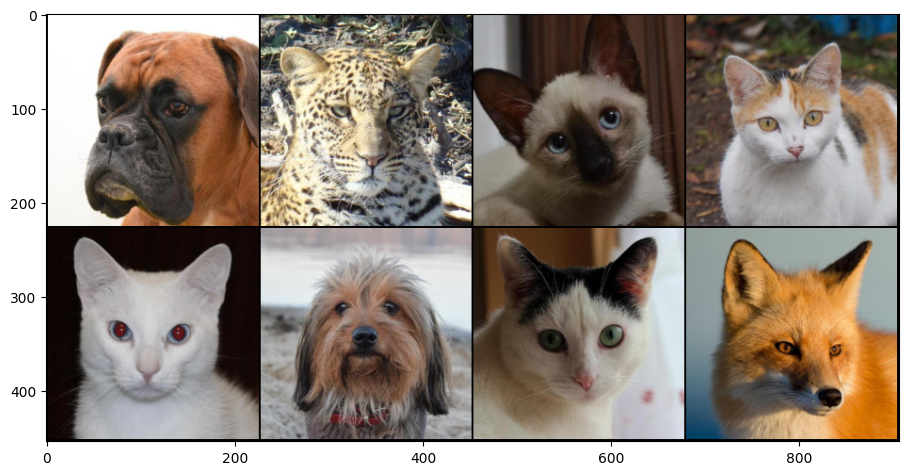

In [ ]:
#Displaying Datset 3
dataset_show_images(dataset3, 8, dataset3_classes, True)

In [ ]:
#ResNet-18
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x




In [ ]:
#Split into train / test
def get_data(dataset):

    n = len(dataset)  # total number of examples
    n_test = int(0.20 * n)  # take ~20% for test
    for x in range(0, 9):  # rounding it to be divisible by 4
        n_test += 1
        if n_test % 4 == 0:
            break
    train_set, test_set = torch.utils.data.random_split(dataset, [n - n_test, n_test])

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size=10, shuffle=False)

    return train, test

In [ ]:
#Setting up Cuda
print(torch.cuda.is_available())
torch.cuda.empty_cache()

# Getting the train/test data
train, test= get_data(dataset1)

# Instanciating the ResNet18 Class created earlier and Assigning it as our model
model = ResNet18(3)

# The loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# momentum=0.9

# Using Cuda cores for the training
model=model.to(torch.device("cuda:0"))


True


In [ ]:
# Training the CNN ResNet-18 Model
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

num_epoch=20
num_epoch_saved=0
lr=0.001
test_size=0


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

running_train_losses = []
running_test_losses = []

#For Saving the model
#'/content/drive/My Drive/Colab Notebooks/Saved models/Latest save'
model_name_to_save = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/{model_name_to_save}"
save_dir_opti=F"/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/{model_name_to_save}"

print("training...")
start.record()
for epoch in range(num_epoch):
    model.train()
    batch_num = 1
    loss_train= 0.0
    correct = 0
    total = 0
    test_size=0

    if epoch>=1:
      state_dict = torch.load(save_dir)
      state_dict_opti = torch.load(save_dir_opti)
      model.load_state_dict(state_dict)
      optimizer.load_state_dict(state_dict_opti)


    for inputs, labels in train:
      #To Cuda
      inputs=inputs.to(torch.device("cuda:0"))
      labels=labels.to(torch.device("cuda:0"))

      optimizer.zero_grad()
      outputs = model(inputs)
      loss_train = criterion(outputs, labels)
      loss_train.backward()
      optimizer.step()

      #Loss by input Train
      loss_by_input=loss_train.item()
      loss_train += loss_train.item()

      # Show results every 15 batches
      if batch_num % 15 == 0 or batch_num == 1:
        print(f"Epoch: {epoch+1}/{num_epoch}, Batch: {batch_num} ,Loss: {loss_by_input}")

      #Accuracy
      total += labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()

      #Incrementing Batch number
      batch_num = batch_num + 1


    # Checking if the loss has improved this epoch. If so it will save that model,
    # otherwise it will just reload the previous  model and continue from there.
    loss_by_epoch=loss_train / len(train)
    print("This epoch:")
    #print(loss_by_epoch.detach().numpy())
    print(loss_by_epoch.detach().cpu().numpy())

    #epoch<=1
    if (True or (loss_by_epoch.detach().cpu().numpy() <= train_losses[-1])):
     #(loss_by_epoch.detach().numpy() <= train_losses[-1])):
      num_epoch_saved=num_epoch_saved+1
      #Save model
      torch.save(model.state_dict(), save_dir)
      torch.save(optimizer.state_dict(), save_dir_opti)
      print('saved!')
      #Loss by batch Train
      #train_losses.append(loss_by_epoch.detach().numpy())
      train_losses.append(loss_by_epoch.detach().cpu().numpy())

      running_train_losses.append(loss_by_input) #New

      #Accuracy by batch Train
      accuracy = correct / total
      train_accuracy.append(accuracy)
      print(f"Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy}")

      #Test
      model.eval()
      loss_test = 0.0
      correct2 = 0
      total2 = 0

      with torch.no_grad():
        for inputs, labels in test:
          #To Cuda
          inputs=inputs.to(torch.device("cuda:0"))
          labels=labels.to(torch.device("cuda:0"))

          outputs = model(inputs)

          test_size+=1

          #Loss Test
          loss_test = criterion(outputs, labels)
          loss_by_input_test=loss_test.item()#New
          loss_test += loss_test.item()

          running_test_losses.append(loss_by_input_test)#New

          #Accuracy Test
          total2 += labels.size(0)
          _, predicted2 = torch.max(outputs.data, 1)
          correct2 += (predicted2 == labels).sum().item()

        loss_by_epoch2=loss_test / len(test)
        #test_losses.append(loss_by_epoch2.detach().numpy())
        test_losses.append(loss_by_epoch2.detach().cpu().numpy())

        accuracy2 = correct2 / total2
        test_accuracy.append(accuracy2)
        print(test_size)

      print("Test end!")

end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

print(num_epoch)
print(len(train_losses))
print(len(test_losses))


#Save model
#torch.save(model.state_dict(), save_dir)
#print('saved')

#del model
torch.cuda.empty_cache()

training...


KeyboardInterrupt: ignored

In [ ]:
#Plotting the training Results!

# # Plot Loss Train
# plt.plot(range(1, num_epoch_saved+1), train_losses, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Training Loss')
# plt.title('Training Loss By Epoch')
# plt.legend()
# plt.show()


# # Plot Accuracy Train
# plt.plot(range(1, num_epoch_saved+1), train_accuracy , label='Training Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Training Accuracy')
# plt.title('Training Accuracy By Epoch')
# plt.legend()
# plt.show()

# # Plot Loss Test
# plt.plot(range(1, num_epoch_saved+1), test_losses, label='Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Testing Loss')
# plt.title('Testing Loss By Epoch')
# plt.legend()
# plt.show()

# # Plot Accuracy Test
# plt.plot(range(1, num_epoch_saved+1), test_accuracy , label='Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Testing Accuracy')
# plt.title('Testing Accuracy By Epoch')
# plt.legend()
# plt.show()


# #By input
# plt.plot(range(1, len(running_train_losses)+1), running_train_losses, label='Training Loss by Inputs')
# plt.xlabel('Inputs')
# plt.ylabel('Training Loss')
# plt.title('Training Loss By Inputs')
# plt.legend()
# plt.show()

# plt.plot(range(1, len(running_test_losses)+1), running_test_losses, label='Testing Loss by Inputs')
# plt.xlabel('Inputs')
# plt.ylabel('Testing Loss')
# plt.title('Testing Loss By Inputs')
# plt.legend()
# plt.show()

In [ ]:
#Classification Report on training data
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

labels_array = []
predictions = []
model.eval()

start.record()
with torch.no_grad():
  for inputs, labels in train:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

print("Finished Training!")
#Classification report
print("Training Results:")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))

684713.9375
Finished Training!
Training Results:
              precision    recall  f1-score   support

        NORM       0.81      0.94      0.87      1606
         MUS       0.80      0.99      0.89      1604
         STR       0.98      0.60      0.74      1596

    accuracy                           0.84      4806
   macro avg       0.87      0.84      0.83      4806
weighted avg       0.87      0.84      0.83      4806



Testing on Dataset #1...
Finished Testing on Dataset #1!
187250.5
Testing Results: 


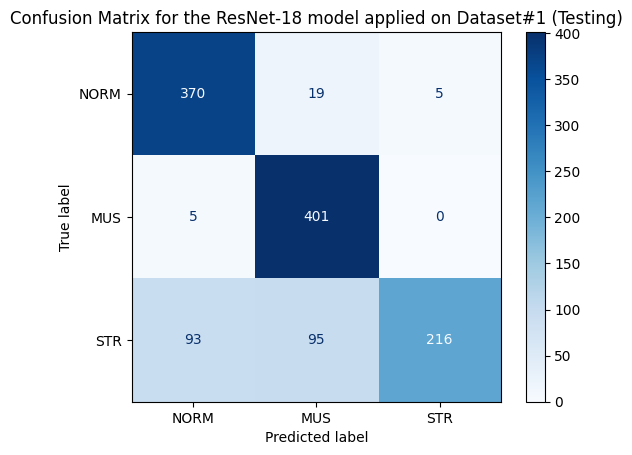

              precision    recall  f1-score   support

        NORM       0.79      0.94      0.86       394
         MUS       0.78      0.99      0.87       406
         STR       0.98      0.53      0.69       404

    accuracy                           0.82      1204
   macro avg       0.85      0.82      0.81      1204
weighted avg       0.85      0.82      0.81      1204



In [ ]:
#Testing the model on Dataset #1
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

print('Testing on Dataset #1...')
labels_array = []
predictions = []

model.eval()
start.record()
with torch.no_grad():
  for inputs, labels in test:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("Finished Testing on Dataset #1!")
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

# Confusion matrix
print("Testing Results: ")
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['NORM', 'MUS', 'STR'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for the ResNet-18 model applied on Dataset#1 (Testing)')
plt.show()

#Classification report
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))

Testing on Dataset #2...
Finished Testing on Dataset #2!
Testing Results: 


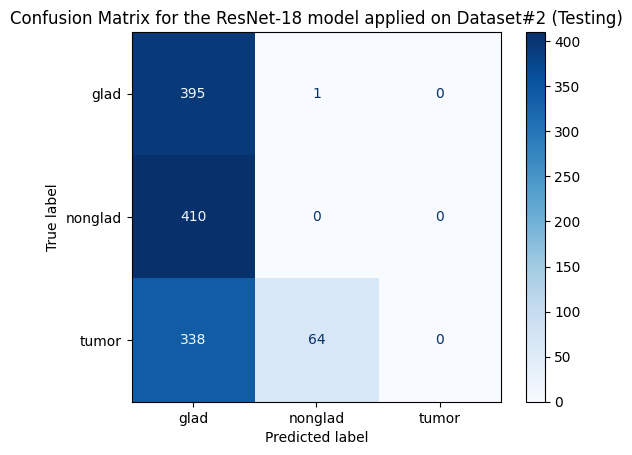

              precision    recall  f1-score   support

        glad       0.35      1.00      0.51       396
     nonglad       0.00      0.00      0.00       410
       tumor       0.00      0.00      0.00       402

    accuracy                           0.33      1208
   macro avg       0.12      0.33      0.17      1208
weighted avg       0.11      0.33      0.17      1208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Testing the model on Dataset #2!

# Load Datset #2 testing data
_, dataset2_test = get_data(dataset2)

#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

print('Testing on Dataset #2...')
labels_array = []
predictions = []

model.eval()

with torch.no_grad():
  for inputs, labels in dataset2_test:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("Finished Testing on Dataset #2!")

# Confusion matrix
print("Testing Results: ")
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['glad', 'nonglad', 'tumor'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for the ResNet-18 model applied on Dataset#2 (Testing)')
plt.show()

#Classification report
print(classification_report(labels_array, predictions, target_names=['glad', 'nonglad', 'tumor']))

Testing on Dataset #3...
Finished Testing on Dataset #3!
Testing Results: 


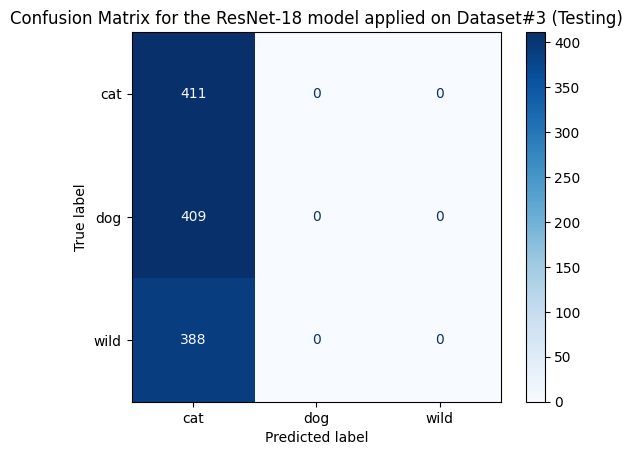

              precision    recall  f1-score   support

         cat       0.34      1.00      0.51       411
         dog       0.00      0.00      0.00       409
        wild       0.00      0.00      0.00       388

    accuracy                           0.34      1208
   macro avg       0.11      0.33      0.17      1208
weighted avg       0.12      0.34      0.17      1208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Testing the model on Dataset #3!

# Load Datset #3 testing data
_, dataset3_test = get_data(dataset3)

#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

print('Testing on Dataset #3...')
labels_array = []
predictions = []

model.eval()

with torch.no_grad():
  for inputs, labels in dataset3_test:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("Finished Testing on Dataset #3!")

# Confusion matrix
print("Testing Results: ")
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['cat', 'dog', 'wild'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for the ResNet-18 model applied on Dataset#3 (Testing)')
plt.show()

#Classification report
print(classification_report(labels_array, predictions, target_names=['cat', 'dog', 'wild']))

In [ ]:
import torch
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

def extract_features(preprocessed_images):
    features = []
    labels = []
    for img_array, category in preprocessed_images:
        image_tensor = torch.tensor(img_array).unsqueeze(0).permute(0, 3, 1, 2)
        with torch.no_grad():
            feature = model(image_tensor.float())
        features.append(feature.flatten().numpy())
        labels.append(category)
    return np.array(features), labels


def visualize_features(features, labels):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    unique_labels = list(set(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(unique_labels):
        indices = [j for j, x in enumerate(labels) if x == label]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], color=colors[i], label=label)
    plt.legend()
    plt.title("Feature Visualization with t-SNE")
    plt.show()